# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle
from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.layouts import widgetbox

from matplotlib.colors import rgb2hex

from operator import itemgetter
from operator import add

%matplotlib inline
plt.style.use("ggplot")
output_notebook()

Loading BokehJS ...

First we create some utilities:
- A tag2name dict that allows us to convert a tagId to a tag name
- The number of distinct movies and distinct tags in the genome-scores file
- Since the movieId are not contiguous, we create a dict that map from (0,number of movies-1) to the movieIds

In [2]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

distinctMovies = data.map(lambda score: score['movieId']).distinct().count()
print('There is %d movies with tags'%distinctMovies)

distinctTags = data.map(lambda score: score['tagId']).distinct().count()
print('There is %d distinct tags'%distinctTags)

movie2Idx = data.map(lambda score: score['movieId']).distinct().zipWithIndex().collectAsMap()

There is 10381 movies with tags
There is 1128 distinct tags


## 3.1
We create the matrix from the data, we will get a matrix of the shape $\text{number of distinct tags } \times \text{ number of disctinct movies}$

We use the previously computed indices for mapping the movies ID to correct index.

In [3]:
matrix = np.zeros((distinctTags,distinctMovies),dtype=np.float64)

for score in data.map(lambda score: (score['movieId'],score['tagId'],score['relevance'])).collect():
    matrix[score[1]-1,movie2Idx[score[0]]] = score[2]

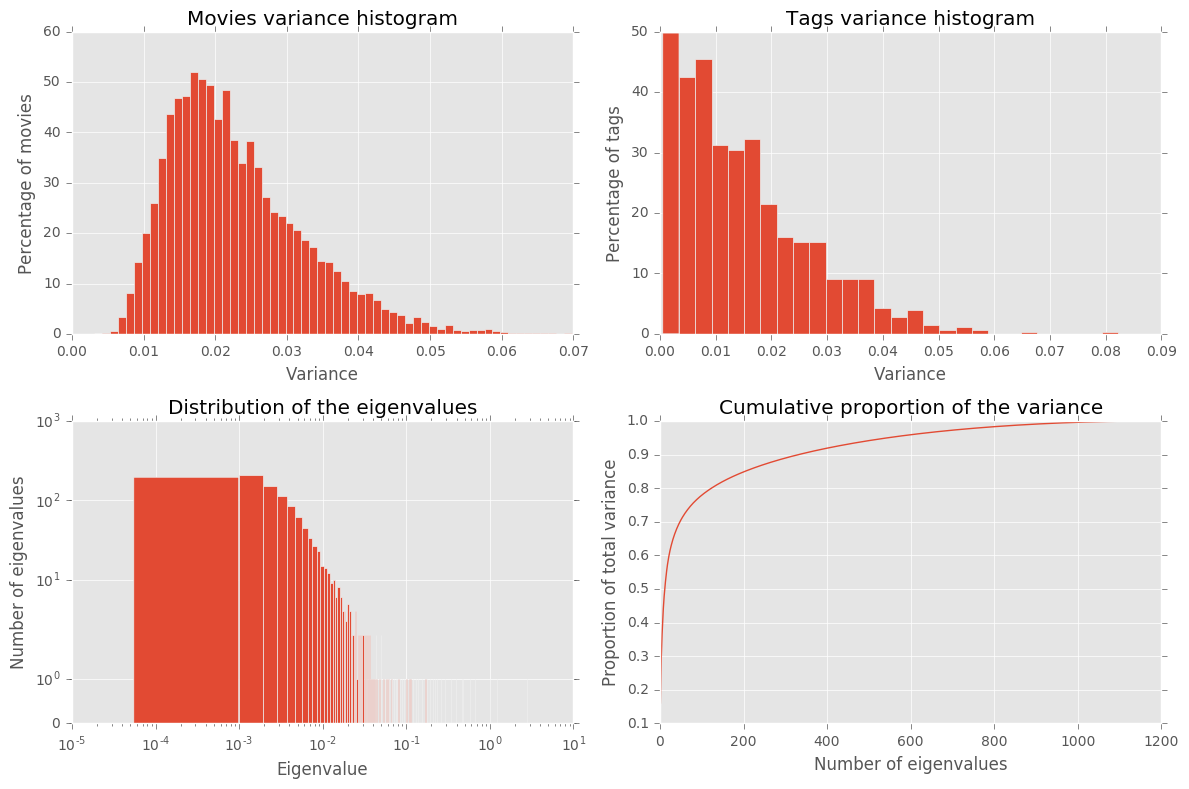

We need 37 principal direction to capture 2/3 of the variability


In [4]:
# computes the variance for each tag
varianceMovies = np.var(matrix, axis=0)
# computes the variance for each tag
varianceTags = np.var(matrix, axis=1)

# We find the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = la.eigh(np.cov(matrix))
# We sort it by biggest eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

totalVar = np.sum(eigenvalues)
# Small function that computes the proportion of variance of the
# first n eigenvalues
def nFirstProportion(n):
    return np.sum(eigenvalues[:n])/totalVar

# Plotting
fig, axes = plt.subplots(2,2,figsize=(12.0,8.0))

ax = axes[0][0]
ax.set_xlabel('Variance')
ax.set_ylabel('Percentage of movies')
ax.set_title('Movies variance histogram')
ax.hist(varianceMovies,bins='auto',normed=True)

ax = axes[0][1]
ax.set_xlabel('Variance')
ax.set_ylabel('Percentage of tags')
ax.set_title('Tags variance histogram')
ax.hist(varianceTags,bins='auto',normed=True)




ax = axes[1][0]
ax.set_xscale('log') 
ax.set_yscale('symlog')
ax.set_xlabel('Eigenvalue')
ax.set_ylabel('Number of eigenvalues')
ax.set_title('Distribution of the eigenvalues')
ax.hist(eigenvalues,'auto')

ax = axes[1][1]
ax.set_xlabel('Number of eigenvalues')
ax.set_ylabel('Proportion of total variance')
ax.set_title('Cumulative proportion of the variance')
ax.plot(np.arange(1,1128),np.vectorize(nFirstProportion)(np.arange(1,1128)))
plt.tight_layout()
plt.show();

for i in range(1,len(eigenvalues)+1):
    if nFirstProportion(i) >= 2/3:
        print("We need %d principal direction to capture 2/3 of the variability"%(i))
        break

In [5]:
# We take the first five eigenvectors
V = eigenvectors[:,:5]

# We create a dictionnary of name to the coordinates in the first principal direction
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tagName2PCA = {}
for tag in data.map(lambda tag: (tag['tag'],tag['tagId'])).collect():
   tagName2PCA[tag[0]] = V[tag[1]-1]
np.save('tag2pca',tagName2PCA)

numTags=5
highTags = np.empty((5, numTags),dtype=object)
lowTags = np.empty((5, numTags),dtype=object)
for i in range (0,5):
    high = eigenvectors[:,i].argsort()[-numTags:][::-1]
    for idx, val in enumerate(high):
        highTags[i][idx] = tag2name[val+1]
    low = eigenvectors[:,i].argsort()[:numTags]
    for idx, val in enumerate(low):
        lowTags[i][idx] = tag2name[val+1]

In [6]:
data = dict(
    highTags=list(map(", ".join,highTags)),
    lowTags=list(map(", ".join,lowTags)),
)
source = ColumnDataSource(data)
columns = [
    TableColumn(field='highTags', title='High coordinates tags'),
    TableColumn(field='lowTags', title='Low coordinates tags'),
]
data_table = DataTable(source=source,columns=columns,width=900,height=100)
show(widgetbox(data_table, sizing_mode = 'scale_both'))

In [7]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
data=dict(
            x=[],
            y=[],
            name=[],
            score=[],
            color=[],
        )

for movie in movies:
    coords = matrix.T[movie2Idx[movie[0]]].dot(eigenvectors[:,:2])
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies scores",x_axis_label='bad movies - good movies',y_axis_label='action - sentimental')

p.circle('x', 'y', size=20, source=source, color='color')

show(p)